## Comparison of adversarial robustness between Liquid Neural Network, CNN, and transformer architecture

The LTC Liquid Neural Network Model is taken/forked from this tutorial repository: https://github.com/KPEKEP/LTCtutorial. This uses the following papers:

*Step-by-Step Guide to Building an LTC Liquid Neural Network from Scratch*, Pavel Nakaznenko, 2024

[Liquid Time-Constant Networks on Arxiv](https://arxiv.org/abs/2006.04439)

Acknowledgement: The tutorial is heavily based on the reference [LTCCell implementation](https://github.com/mlech26l/ncps/blob/master/ncps/torch/ltc_cell.py), thanks to the authors of LNN.

[Telegram channel: ToShoSeti](https://t.me/toshoseti)

# LTC Neural Network Model

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim

*Implementing the RandomWiring Class*

The RandomWiring class is responsible for defining the connection architecture between neurons. It initializes random adjacency matrices for neuron connections and sensory inputs. Those are used as an arbitrary sparsity matrix later in LIFNeuralLayer

In [10]:
class RandomWiring:
    def __init__(self, input_dim, output_dim, neuron_count):
        self.input_dim = input_dim  # Number of input features
        self.output_dim = output_dim  # Number of output features
        self.neuron_count = neuron_count  # Number of neurons in the layer
        self.adjacency_matrix = np.random.uniform(0, 1, (neuron_count, neuron_count))  # Adjacency matrix for connections between neurons
        self.sensory_adjacency_matrix = np.random.uniform(0, 1, (input_dim, neuron_count))  # Adjacency matrix for sensory inputs to neurons

    def erev_initializer(self):
        return np.random.uniform(-0.2, 0.2, (self.neuron_count, self.neuron_count))  # Initialize reversal potentials for neuron connections

    def sensory_erev_initializer(self):
        return np.random.uniform(-0.2, 0.2, (self.input_dim, self.neuron_count))  # Initialize reversal potentials for sensory inputs

## Implementing the LIFNeuronLayer Class
The LIFNeuronLayer class models the behavior of a layer of Leaky Integrate-and-Fire neurons. It initializes neuron parameters and defines the forward pass for computing neuron states. LIF dynamics are described using ODE and during the forward pass we solve the states using Euler Explicit method, described in the original article.

In [11]:
# LIFNeuronLayer class explanation:

"""
The LIFNeuronLayer class is a PyTorch module that models a layer of Leaky Integrate-and-Fire (LIF) neurons, commonly used in spiking neural networks. It is designed to simulate the dynamics of neurons using an ordinary differential equation (ODE) solver. The class takes a wiring object as input, which contains the structural and connectivity information of the neurons, and initializes various parameters required for the simulation.

In the constructor (__init__), the class initializes several neuron-specific parameters such as leak conductance (gleak), leak voltage (vleak), membrane capacitance (cm), and synaptic weights (w). These parameters are randomly initialized within predefined ranges to simulate biological variability. Additionally, sensory-specific parameters like sensory weights (sensory_w), sensory mean (sensory_mu), and sensory standard deviation (sensory_sigma) are also initialized. Fixed sparsity masks are created based on the adjacency matrices provided by the wiring object to enforce the connectivity structure.

The forward method serves as the entry point for the layer's computation. It delegates the computation to the ode_solver method, which iteratively solves the ODE governing the neuron dynamics. The solver computes the membrane potential (v_pre) over multiple time steps (ode_unfolds) by incorporating sensory inputs, synaptic connections, and leak dynamics. Sensory inputs are pre-computed using a softplus activation function and a custom sigmoid function, which applies a mean shift and scaling to the inputs.

Within the ODE solver, the neuron dynamics are updated iteratively. For each time step, the synaptic activations are computed based on the previous membrane potential, and the contributions from sensory and synaptic inputs are combined. The membrane potential is updated using a weighted sum of these inputs, leak dynamics, and membrane capacitance, ensuring numerical stability by adding a small epsilon value to the denominator.

The sigmoid method is a helper function that applies a scaled and shifted sigmoid activation to the input voltage. This is used to model the non-linear response of neurons to their inputs. Overall, the LIFNeuronLayer class provides a biologically inspired simulation of spiking neurons, making it suitable for tasks involving spiking neural networks or neuromorphic computing.
"""

class LIFNeuronLayer(nn.Module):
    def __init__(self, wiring, ode_unfolds=12, epsilon=1e-8):
        super(LIFNeuronLayer, self).__init__()
        self.wiring = wiring  # Wiring object containing connection information
        self.ode_unfolds = ode_unfolds  # Number of ODE solver iterations
        self.epsilon = epsilon  # Small value to avoid division by zero
        self.softplus = nn.Softplus()  # Softplus activation function

        # Initialization ranges for parameters
        GLEAK_MIN, GLEAK_MAX = 0.001, 1.0
        VLEAK_MIN, VLEAK_MAX = -0.2, 0.2
        CM_MIN, CM_MAX = 0.4, 0.6
        W_MIN, W_MAX = 0.001, 1.0
        SIGMA_MIN, SIGMA_MAX = 3, 8
        MU_MIN, MU_MAX = 0.3, 0.8
        SENSORY_W_MIN, SENSORY_W_MAX = 0.001, 1.0
        SENSORY_SIGMA_MIN, SENSORY_SIGMA_MAX = 3, 8
        SENSORY_MU_MIN, SENSORY_MU_MAX = 0.3, 0.8

        # Initialize neuron parameters with random values within specified ranges
        self.gleak = nn.Parameter(torch.rand(wiring.neuron_count) * (GLEAK_MAX - GLEAK_MIN) + GLEAK_MIN)
        self.vleak = nn.Parameter(torch.rand(wiring.neuron_count) * (VLEAK_MAX - VLEAK_MIN) + VLEAK_MIN)
        self.cm = nn.Parameter(torch.rand(wiring.neuron_count) * (CM_MAX - CM_MIN) + CM_MIN)
        self.w = nn.Parameter(torch.rand(wiring.neuron_count, wiring.neuron_count) * (W_MAX - W_MIN) + W_MIN)
        self.sigma = nn.Parameter(torch.rand(wiring.neuron_count, wiring.neuron_count) * (SIGMA_MAX - SIGMA_MIN) + SIGMA_MIN)
        self.mu = nn.Parameter(torch.rand(wiring.neuron_count, wiring.neuron_count) * (MU_MAX - MU_MIN) + MU_MIN)
        self.erev = nn.Parameter(torch.Tensor(wiring.erev_initializer()))
        
        # Initialize sensory parameters with random values within specified ranges
        self.sensory_w = nn.Parameter(torch.rand(wiring.input_dim, wiring.neuron_count) * (SENSORY_W_MAX - SENSORY_W_MIN) + SENSORY_W_MIN)
        self.sensory_sigma = nn.Parameter(torch.rand(wiring.input_dim, wiring.neuron_count) * (SENSORY_SIGMA_MAX - SENSORY_SIGMA_MIN) + SENSORY_SIGMA_MIN)
        self.sensory_mu = nn.Parameter(torch.rand(wiring.input_dim, wiring.neuron_count) * (SENSORY_MU_MAX - SENSORY_MU_MIN) + SENSORY_MU_MIN)
        self.sensory_erev = nn.Parameter(torch.Tensor(wiring.sensory_erev_initializer()))

        # Sparsity masks (fixed, non-learnable) based on the wiring adjacency matrices
        self.sparsity_mask = torch.Tensor(np.abs(wiring.adjacency_matrix))
        self.sensory_sparsity_mask = torch.Tensor(np.abs(wiring.sensory_adjacency_matrix))

    def forward(self, inputs, state, elapsed_time=1.0):
        return self.ode_solver(inputs, state, elapsed_time)

    def ode_solver(self, inputs, state, elapsed_time):
        v_pre = state  # Previous state (voltage)

        # Pre-compute the effects of the sensory neurons
        sensory_activation = self.softplus(self.sensory_w) * self.sigmoid(inputs, self.sensory_mu, self.sensory_sigma)
        sensory_activation = sensory_activation * self.sensory_sparsity_mask
        sensory_reversal_activation = sensory_activation * self.sensory_erev

        # Calculate the numerator and denominator for sensory inputs
        w_numerator_sensory = torch.sum(sensory_reversal_activation, dim=1)
        w_denominator_sensory = torch.sum(sensory_activation, dim=1)

        # Calculate membrane capacitance over time
        cm_t = self.softplus(self.cm) / (elapsed_time / self.ode_unfolds)

        # Initialize weights for neuron connections
        w_param = self.softplus(self.w)
        for _ in range(self.ode_unfolds):
            # Activation based on previous state
            w_activation = w_param * self.sigmoid(v_pre, self.mu, self.sigma)
            w_activation = w_activation * self.sparsity_mask
            reversal_activation = w_activation * self.erev

            # Calculate the numerator and denominator for neuron connections
            w_numerator = torch.sum(reversal_activation, dim=1) + w_numerator_sensory
            w_denominator = torch.sum(w_activation, dim=1) + w_denominator_sensory

            # Leak conductance and voltage calculations
            gleak = self.softplus(self.gleak)
            numerator = cm_t * v_pre + gleak * self.vleak + w_numerator
            denominator = cm_t + gleak + w_denominator

            # Update the state (voltage)
            v_pre = numerator / (denominator + self.epsilon)

        return v_pre

    def sigmoid(self, v_pre, mu, sigma):
        v_pre = torch.unsqueeze(v_pre, -1)  # Unsqueeze to match dimensions
        activation = sigma * (v_pre - mu)  # Apply sigma and mean shift
        return torch.sigmoid(activation)  # Apply sigmoid activation

### Understanding the LIF Neural Layer

The Leaky Integrate-and-Fire (LIF) neuron is a simple and widely used model in computational neuroscience. It simulates how biological neurons integrate incoming signals and fire when a threshold is reached. The LIF model captures the essential features of real neurons and is computationally efficient.

#### Mathematical Formulation of LIF Neurons

The LIF neuron can be described by the following differential equation:

$$\tau_m \frac{dV(t)}{dt} = -V(t) + R_m I(t)$$

Where:
- $V(t)$ is the membrane potential at time $t$.
- $\tau_m$ is the membrane time constant.
- $R_m$ is the membrane resistance.
- $I(t)$ is the input current at time $t$.

When the membrane potential $V(t)$ reaches a certain threshold $V_{\text{th}}$, the neuron fires an action potential (or spike), and $V(t)$ is reset to a lower value, often $V_{\text{reset}}$.

#### Implementation in the LIFNeuronLayer Class

The `LIFNeuronLayer` class in our implementation simulates a layer of LIF neurons with specific parameters for the membrane potential, conductance, and input weights. Let's break down its components and their roles.

##### Initialization

The class initializes several parameters that control the behavior of the neurons, including:
- **gleak**: Leak conductance.
- **vleak**: Leak voltage.
- **cm**: Membrane capacitance.
- **w, sigma, mu**: Parameters for the weights and activation functions.
- **erev**: Reversal potentials for neuron connections.
- **sensory_w, sensory_sigma, sensory_mu, sensory_erev**: Parameters for sensory inputs.

#### Reversal Activation

- **Reversal Activation**: This represents the influence of synaptic reversal potentials on the membrane potential. In biological neurons, the reversal potential is the voltage at which a specific ion's net flow through the membrane is zero. Incorporating reversal potentials into the model helps simulate realistic synaptic interactions.
- **Calculation**: It involves multiplying the activation by the reversal potential matrix, which influences the neuron's state update during the forward pass. This mechanism helps integrate the effects of excitatory and inhibitory synapses.

##### Forward Pass and ODE Solver

The forward pass of the `LIFNeuronLayer` involves solving the differential equation that governs the membrane potential dynamics. This is done using an iterative approach with multiple ODE unfolds.

Here’s a simplified explanation:
1. **Pre-compute Sensory Effects**: Calculate the sensory activation and reversal activation based on the input.
2. **ODE Solver Loop**: Iteratively update the neuron states using the ODE solver. This involves computing activations, applying sparsity masks, and updating the voltage states.

##### Sigmoid Function

The classic sigmoid function scales the inputs to a range between 0 and 1, which is essential for the activation of neurons. It is used both for the neuron connections and the sensory inputs.
The sigmoid function in the LIFNeuronLayer class is customized to include parameters mu (mean) and sigma (scale). This customized implementation allows for more flexible and controlled activation behavior compared to the classic torch.sigmoid. 

1. **Parameter `mu` (Mean Shift)**:
   - The `mu` parameter shifts the input voltage (`v_pre`). This shift allows the activation function to be centered around different mean values.
   - Mathematically, `v_pre - mu` shifts the input such that the midpoint (where the sigmoid is 0.5) is not necessarily zero but `mu`.

2. **Parameter `sigma` (Scale)**:
   - The `sigma` parameter scales the input voltage (`v_pre`). This scaling controls the steepness of the sigmoid function.
   - Mathematically, `sigma * (v_pre - mu)` adjusts the slope of the sigmoid curve. A larger `sigma` makes the sigmoid steeper, while a smaller `sigma` makes it more gradual.

The customized sigmoid function is used to provide greater flexibility in the neural network's activation dynamics. Here's why this flexibility is important:

1. **Biological Realism**:
   - Biological neurons do not have a fixed activation threshold or response curve. The response curve can shift and scale depending on various factors.
   - By incorporating `mu` and `sigma`, we can simulate this variability, making the model more biologically plausible.

2. **Improved Learning**:
   - Neural networks can benefit from adaptive activation functions. Different layers or neurons might require different activation behaviors to learn complex patterns effectively.
   - The parameters `mu` and `sigma` can be learned during training, allowing the network to adjust its activation functions dynamically.

3. **Enhanced Control**:
   - In some cases, having control over the activation function's mean and scale can improve the network's ability to handle different input ranges and distributions.
   - This customization can lead to better convergence and performance in certain tasks, especially in those involving varied and complex input signals.

#### Why Random Adjacency and Sparsity Masks?

- **Random Adjacency Matrix**: This matrix defines the connections between neurons in a random manner, simulating the complex and non-regular connectivity found in biological neural networks. It introduces variability and complexity in the network, which can help in learning more diverse patterns.
- **Sparsity Mask**: This mask ensures that only certain connections are active, enforcing sparsity in the network. Sparse connections mimic the brain's efficient wiring, where not every neuron is connected to every other neuron, reducing computational load and preventing overfitting.

## Implementing the LTCCell Class
The LTCCell class represents a single cell in the Liquid Time-Constant Recurrent Neural Network. It uses the LIFNeuronLayer to update neuron states.

Note: we assume that the amount of neurons is always greater than the output dimmension, so we just trim them into outputs. Should that not be the case, feel free to use additional fully connected layer to project the hidden states into outputs.

In [12]:
class LTCCell(nn.Module):
    def __init__(self, wiring, in_features=None, ode_unfolds=6, epsilon=1e-8):
        super(LTCCell, self).__init__()        
        self.wiring = wiring  # Wiring object
        self.ode_unfolds = ode_unfolds  # Number of ODE solver iterations
        self.epsilon = epsilon  # Small value to avoid division by zero

        self.neuron = LIFNeuronLayer(wiring, ode_unfolds, epsilon)  # Initialize LIFNeuron with the given wiring

    def forward(self, inputs, states, elapsed_time=1.0):
        next_state = self.neuron(inputs, states, elapsed_time)  # Compute the next state using the neuron model
        outputs = next_state[:, :self.wiring.output_dim] # Map the state to the output dimensions
        return outputs, next_state

## Implementing the LTCRNN Class
The LTCRNN class constructs the recurrent neural network using multiple LTCCell instances. It processes sequences of inputs to produce sequences of outputs.

Note: In this tutorial, the LTCRNN is supposed to be called one shot, for the whole sequence, hence the state initialization to zero in each forward pass.

In [13]:
class LTCRNN(nn.Module):
    def __init__(self, wiring, input_dim, hidden_dim, output_dim):
        super(LTCRNN, self).__init__()
        self.cell = LTCCell(wiring, in_features=input_dim)  # Initialize LTCCell with wiring and input dimension
        self.hidden_dim = hidden_dim  # Number of hidden neurons
        self.output_dim = output_dim  # Number of output neurons
        
    def forward(self, inputs):
        batch_size, seq_len, _ = inputs.size()  # Get batch size and sequence length from input dimensions
        
        states = torch.zeros(batch_size, self.hidden_dim)  # Initialize hidden states with zeros
            
        outputs = []  # List to store outputs for each time step

        for t in range(seq_len):
            output, states = self.cell(inputs[:, t, :], states)  # Compute output and next state for each time step
            outputs.append(output)  # Append the output to the list

        result = torch.stack(outputs, dim=1)  # Stack the outputs along the sequence dimension
        return result

## Generating Spiral Data
We will generate a dataset of spiral trajectories to train and evaluate our model. The generate_spiral_data function creates synthetic data points forming a spiral pattern.

In [14]:
# Generate spiral data
def generate_spiral_data(num_points, num_turns, noise = 2):
    theta = np.linspace(0, num_turns * 2 * np.pi, num_points)
    z = np.linspace(0, 1, num_points)
    r = z
    x = r * np.sin(theta) + noise * np.random.randn(*theta.shape) / num_points
    y = r * np.cos(theta) + noise * np.random.randn(*theta.shape) / num_points
    return np.stack([x, y], axis=1)

## (De)normalisation Helper Functions

In [15]:
def compute_stats(data):
    mean = np.mean(data, axis=0, keepdims=True)  # shape: (2,)
    std = np.std(data, axis=0, keepdims=True)    # shape: (2,)
    return mean, std

def normalise(data, mean=None, std=None):
    # Normalise 2D (N, 2) data using per-dimension z-score normalization
    if mean is None or std is None:
        mean, std = compute_stats(data)
    return ((data - mean) / std, mean, std)

def denormalise(data, mean=None, std=None):
    # Revert normalisation to get original 2D data.
    if mean is None or std is None:
        mean, std = compute_stats(data)
    return ((data * std) + mean, mean, std)

## Training the Model
Next, we set the hyperparameters and prepare the data for training. We define a training loop to train the model using the generated spiral data.

Epoch [100/2000], Total train loss: 0.3912, Total val loss: 0.0213


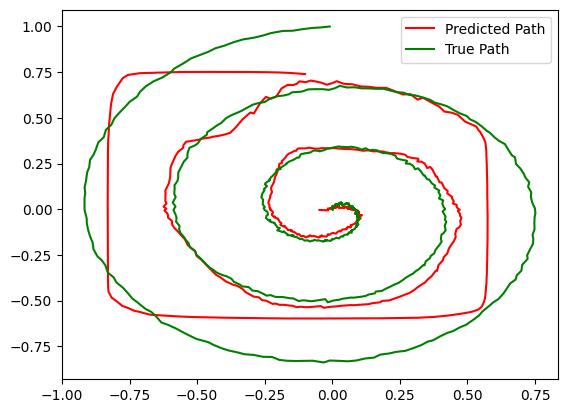

Epoch [200/2000], Total train loss: 0.0691, Total val loss: 0.0056


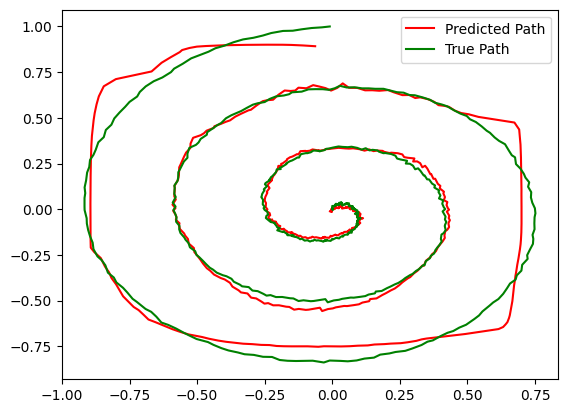

Epoch [300/2000], Total train loss: 0.0440, Total val loss: 0.0036


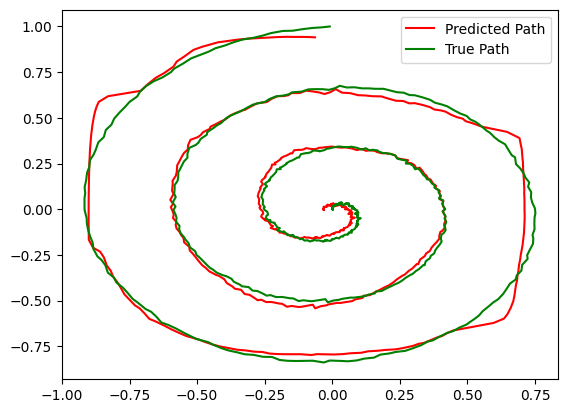

Epoch [400/2000], Total train loss: 0.0208, Total val loss: 0.0014


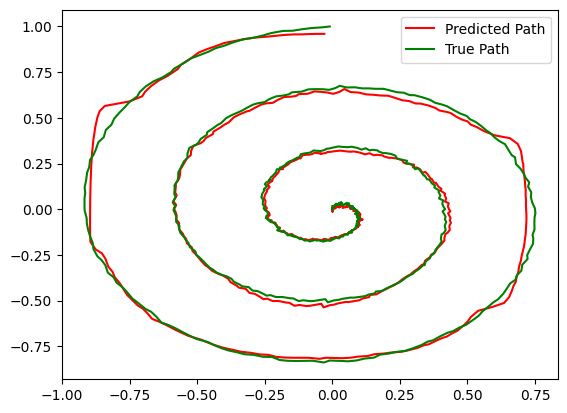

Epoch [500/2000], Total train loss: 0.0245, Total val loss: 0.0009


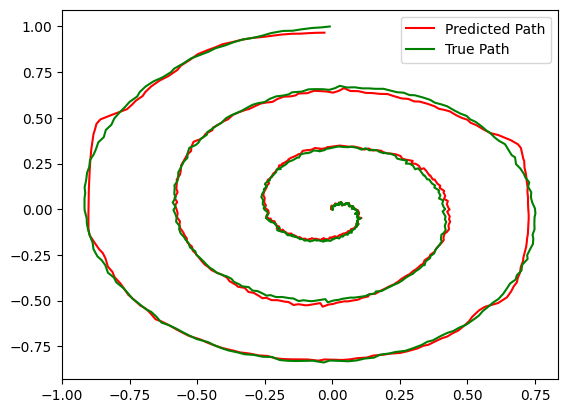

Epoch [600/2000], Total train loss: 0.0173, Total val loss: 0.0008


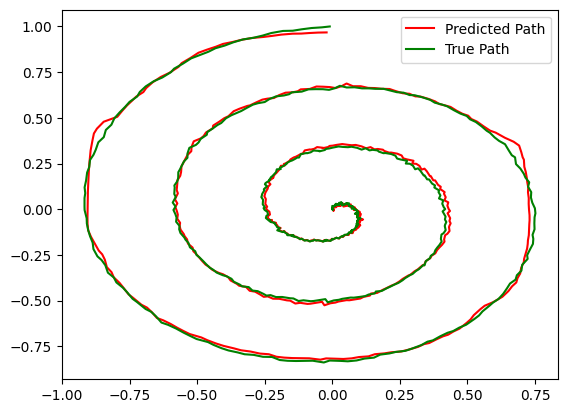

Epoch [700/2000], Total train loss: 0.0211, Total val loss: 0.0012


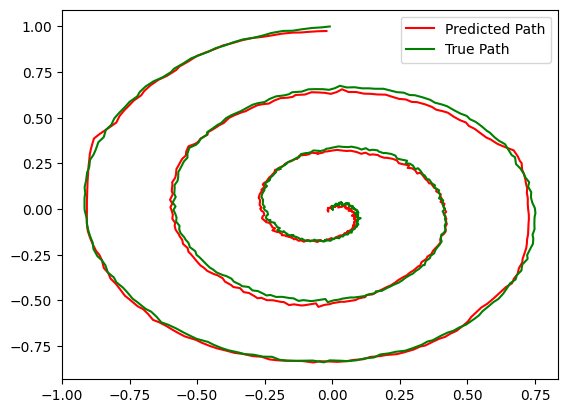

Epoch [800/2000], Total train loss: 0.0145, Total val loss: 0.0005


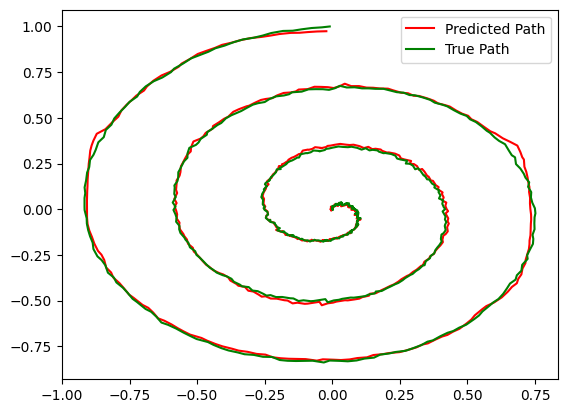

Epoch [900/2000], Total train loss: 0.0233, Total val loss: 0.0009


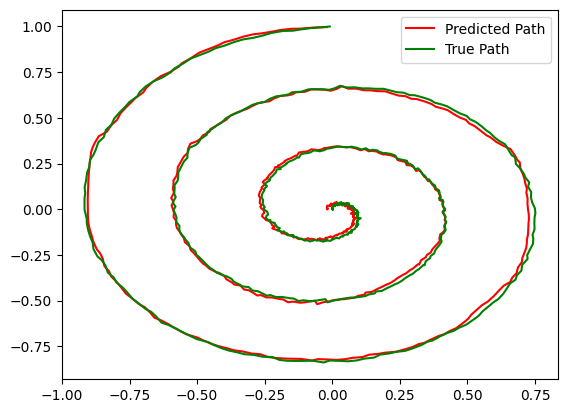

Epoch [1000/2000], Total train loss: 0.0201, Total val loss: 0.0005


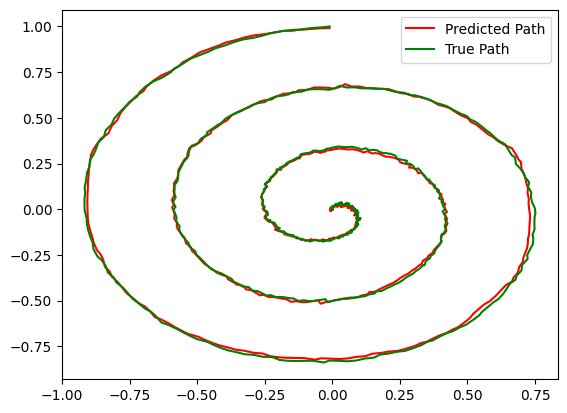

Epoch [1100/2000], Total train loss: 0.0145, Total val loss: 0.0008


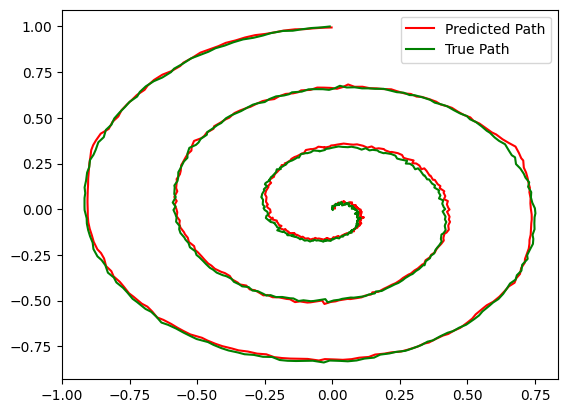

Epoch [1200/2000], Total train loss: 0.0109, Total val loss: 0.0004


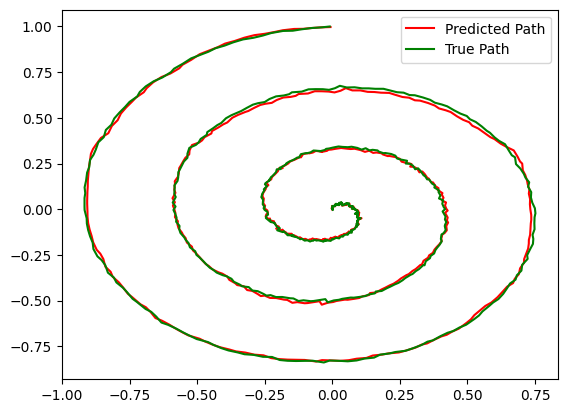

Epoch [1300/2000], Total train loss: 0.0124, Total val loss: 0.0008


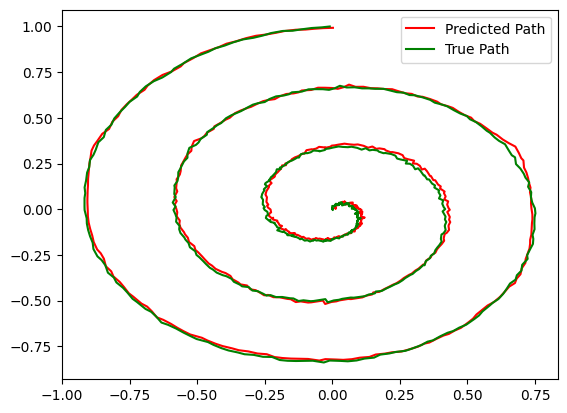

Epoch [1400/2000], Total train loss: 0.0175, Total val loss: 0.0014


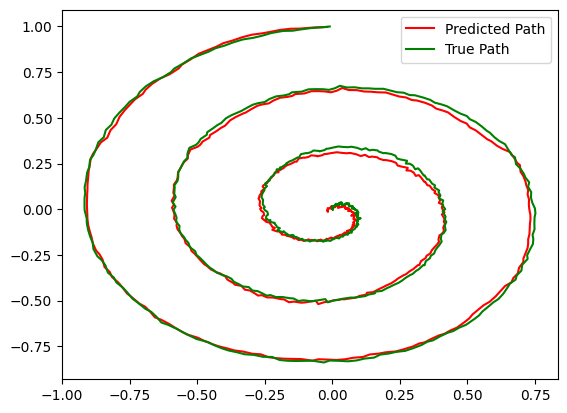

Epoch [1500/2000], Total train loss: 0.0091, Total val loss: 0.0004


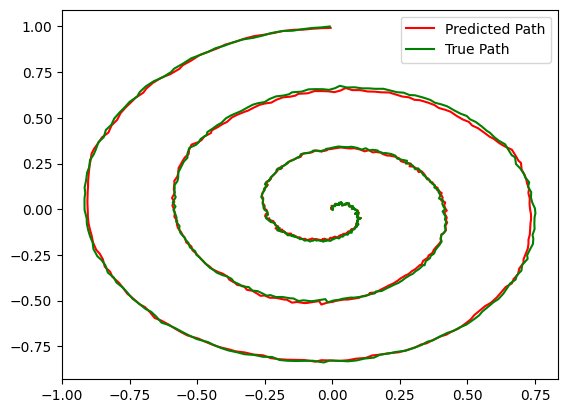

Epoch [1600/2000], Total train loss: 0.0093, Total val loss: 0.0004


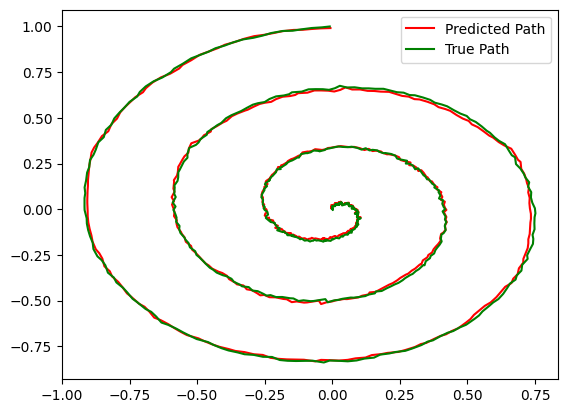

Epoch [1700/2000], Total train loss: 0.0120, Total val loss: 0.0006


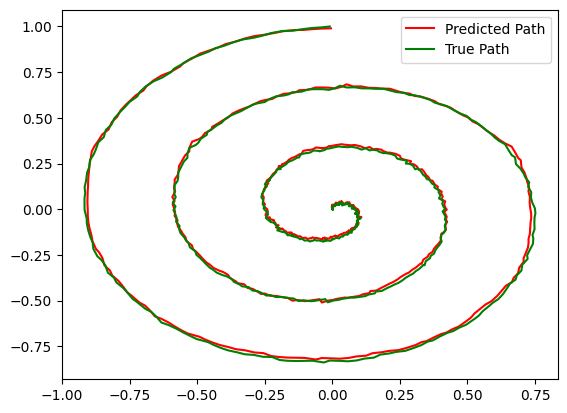

Epoch [1800/2000], Total train loss: 0.0101, Total val loss: 0.0005


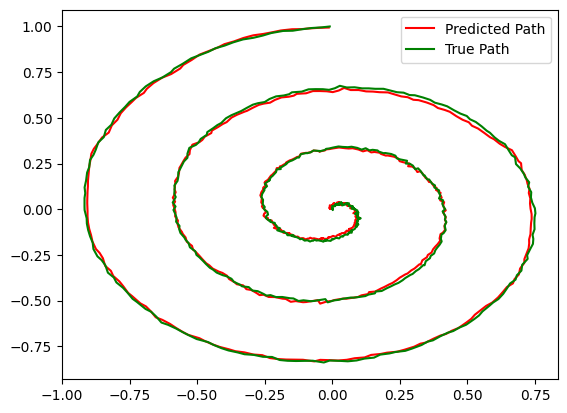

Epoch [1900/2000], Total train loss: 0.0207, Total val loss: 0.0006


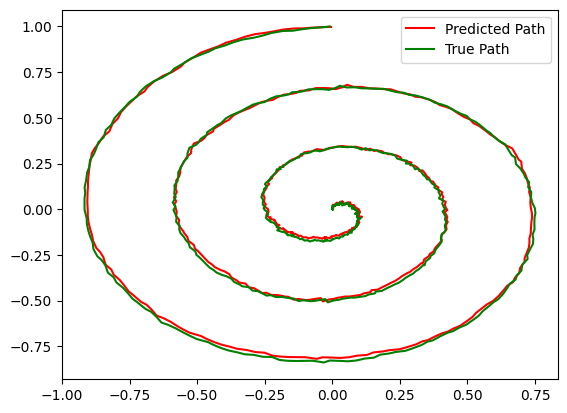

Epoch [2000/2000], Total train loss: 0.0180, Total val loss: 0.0007


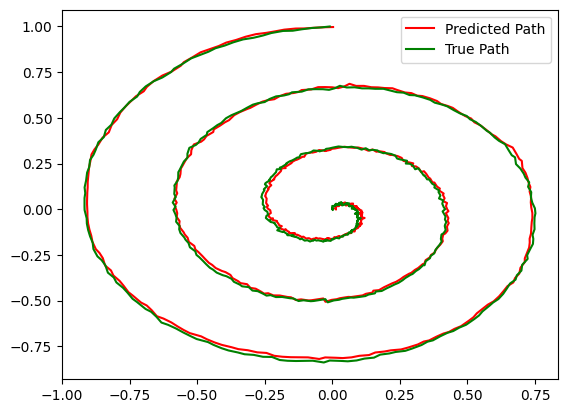

In [16]:
# Hyperparameters
input_dim = 2 # Number of input dimensions
hidden_dim = 8 # Number of hidden dimensions (number of neurons in LIFNeuralLayer)
output_dim = 2 # Number of output dimensions
num_points = 500 # Number of spiral points in dataset
num_turns = 3 # Number of spiral turns
learning_rate = 0.005
num_epochs = 2000
seq_len = 3 # Maximum length of the sample sequence
batch_size = 32

# Generate data
sample_data = generate_spiral_data(num_points, num_turns)

# Normalise data (both inputs and targets)
sample_data, mean, std = normalise(sample_data)

all_inputs = sample_data[:-1, :]
all_targets = sample_data[1:, :]

# Prepare input and target sequences
trajectory_count = max(1, len(all_inputs) - seq_len)
train_inputs = [torch.FloatTensor(all_inputs[i:i + seq_len]) for i in range(trajectory_count)]
train_targets = [torch.FloatTensor(all_targets[i:i + seq_len]) for i in range(trajectory_count)]

# Shuffle and split the data for training
random_train_indices = np.arange(len(train_inputs))
np.random.shuffle(random_train_indices)
train_split_index = int(len(random_train_indices) * 0.8)
random_train_indices = random_train_indices[:train_split_index]

# Function to create batches
def create_batches(data_list, batch_size):
    return [data_list[i:i + batch_size] for i in range(0, len(data_list), batch_size)]

# Create input and target batches
train_input_batches = create_batches(train_inputs, batch_size)
train_target_batches = create_batches(train_targets, batch_size)

# Initialize model
wiring = RandomWiring(input_dim, output_dim, hidden_dim)
lnn_model = LTCRNN(wiring, input_dim, hidden_dim, output_dim)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(lnn_model.parameters(), lr=learning_rate)

# Training loop
for epoch in range(num_epochs):
    lnn_model.train()    
    total_loss = 0

    # Iterate over batches
    for x, y_target in zip(train_input_batches, train_target_batches):
        optimizer.zero_grad()
        x = torch.stack(x)  # Stack batch of sequences
        y_target = torch.stack(y_target)  # Stack batch of targets
        outputs = lnn_model(x)  # Forward pass through the lnn_model
        loss = criterion(outputs, y_target)  # Compute loss

        # Accumulate total loss and perform backward pass and optimization step
        total_loss += loss.item()
        loss.backward()
        optimizer.step()

    # Print loss every 100 epochs and plot predictions
    if (epoch + 1) % 100 == 0:
        # Prediction and plotting
        lnn_model.eval()
        with torch.no_grad():
            predictions = lnn_model(torch.FloatTensor(all_inputs).unsqueeze(0))
            np_predictions = np.array(predictions.squeeze(0).tolist())
            val_loss = criterion(predictions, torch.FloatTensor(all_targets).unsqueeze(0))  # Compute loss
        print(f'Epoch [{epoch+1}/{num_epochs}], Total train loss: {total_loss:.4f}, Total val loss: {val_loss:.4f}')

        # Denormalise predictions and targets for plotting in original data space
        np_predictions_denorm, _, _ = denormalise(np_predictions, mean, std)
        all_targets_denorm, _, _ = denormalise(all_targets, mean, std)

        plt.plot(np_predictions_denorm[:, 0], np_predictions_denorm[:, 1], 'r-', label='Predicted Path')
        plt.plot(all_targets_denorm[:, 0], all_targets_denorm[:, 1], 'g-', label='True Path')
        plt.legend()
        plt.show()

In [17]:
# Save the model (not the state dict)
torch.save(lnn_model, "lnn_model.pt")

In [18]:
# Load the model
lnn_model = torch.load("lnn_model.pt", weights_only=False)

# CNN Model

To compare adversarial robustness of CNN against LNN (by running the same adversarial attacks on CNN)

In [22]:
# class CNN(nn.Module):
#     def __init__(self, input_dim=2, hidden_channels=64, output_dim=2):
#         super(CNN, self).__init__()
#         self.conv1 = nn.Conv1d(input_dim, hidden_channels, kernel_size=3, padding=1)
#         self.conv2 = nn.Conv1d(hidden_channels, hidden_channels, kernel_size=3, padding=1)
#         self.conv3 = nn.Conv1d(hidden_channels, output_dim, kernel_size=1)
#         self.dropout = nn.Dropout(0.2)

#     def forward(self, x):
#         x = x.permute(0, 2, 1)  # [B, C, T]
#         x = F.relu(self.conv1(x))
#         x = self.dropout(x)
#         x = F.relu(self.conv2(x))
#         x = self.conv3(x)
#         return x.permute(0, 2, 1)  # [B, T, C]

# class CNN(nn.Module):
#     def __init__(self, input_dim=2, hidden_channels=64, output_dim=2):
#         super(CNN, self).__init__()
#         self.conv1 = nn.Conv1d(input_dim, hidden_channels, kernel_size=3, padding=1)
#         self.conv2 = nn.Conv1d(hidden_channels, hidden_channels, kernel_size=3, padding=1)
#         self.conv3 = nn.Conv1d(hidden_channels, hidden_channels, kernel_size=3, padding=1)
#         self.out = nn.Conv1d(hidden_channels, output_dim, kernel_size=1)
#         self.dropout = nn.Dropout(0.5)

#     def forward(self, x):
#         x = x.permute(0, 2, 1)  # [B, C, T]
#         x = F.relu(self.conv1(x))
#         x = F.relu(self.conv2(x))
#         x = self.dropout(x)
#         x = F.relu(self.conv3(x))
#         x = self.out(x)
#         return x.permute(0, 2, 1)  # [B, T, C]

class CNN(nn.Module):
    def __init__(self, input_dim=2, hidden_channels=128, output_dim=2):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv1d(input_dim, hidden_channels, kernel_size=5, padding=2)
        self.conv2 = nn.Conv1d(hidden_channels, hidden_channels, kernel_size=5, padding=2)
        self.conv3 = nn.Conv1d(hidden_channels, hidden_channels, kernel_size=3, padding=1)
        self.conv4 = nn.Conv1d(hidden_channels, output_dim, kernel_size=1)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = x.permute(0, 2, 1)  # [B, C, T]
        x = F.relu(self.conv1(x))
        x = self.dropout(x)
        x = F.relu(self.conv2(x))
        x = self.dropout(x)
        x = F.relu(self.conv3(x))
        x = self.conv4(x)
        return x.permute(0, 2, 1)  # [B, T, C]


Epoch [100/3000], Train Loss: 0.1380, Val Loss: 0.0333


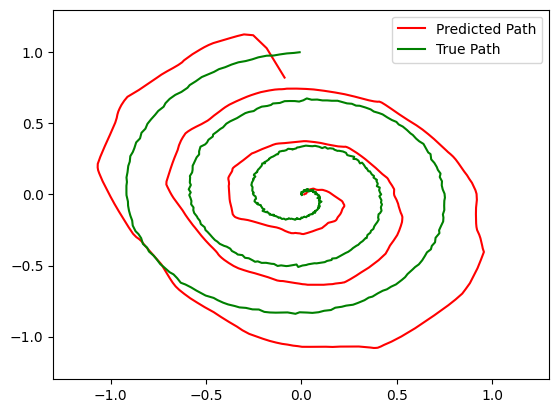

Epoch [200/3000], Train Loss: 0.1086, Val Loss: 0.0287


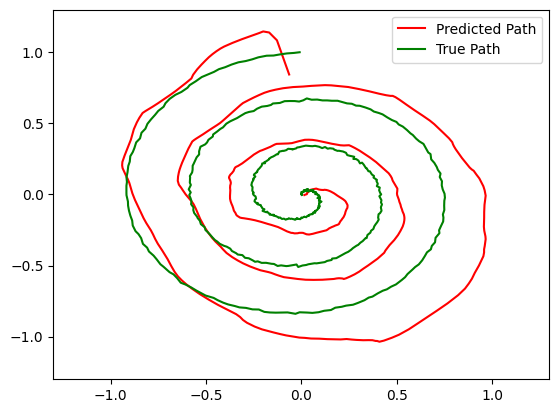

Epoch [300/3000], Train Loss: 0.1014, Val Loss: 0.0276


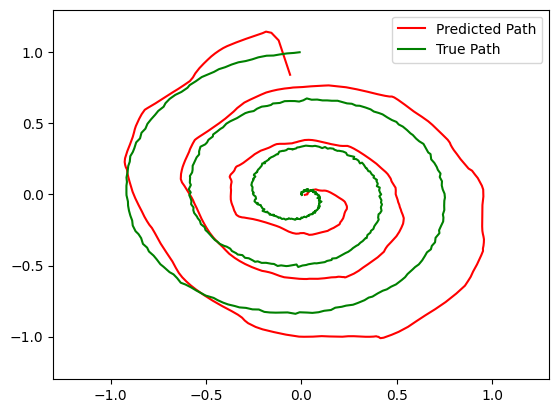

Epoch [400/3000], Train Loss: 0.0978, Val Loss: 0.0271


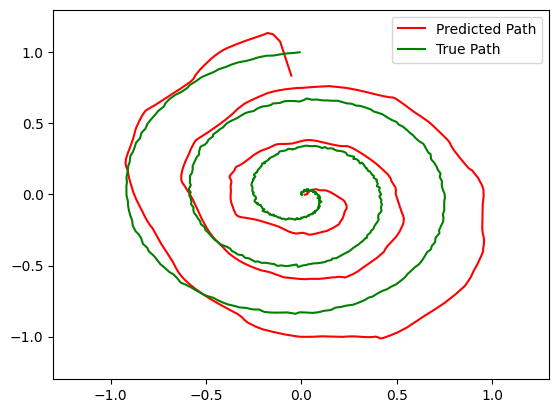

Epoch [500/3000], Train Loss: 0.0891, Val Loss: 0.0269


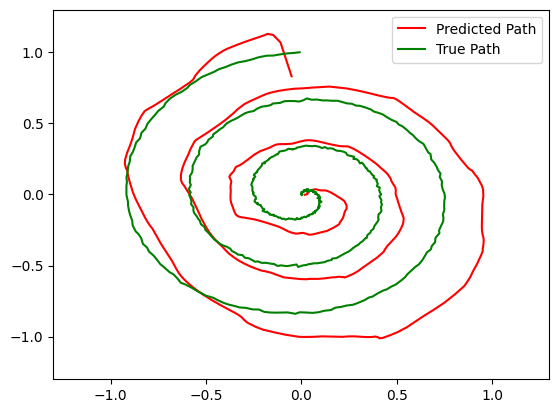

Epoch [600/3000], Train Loss: 0.0866, Val Loss: 0.0271


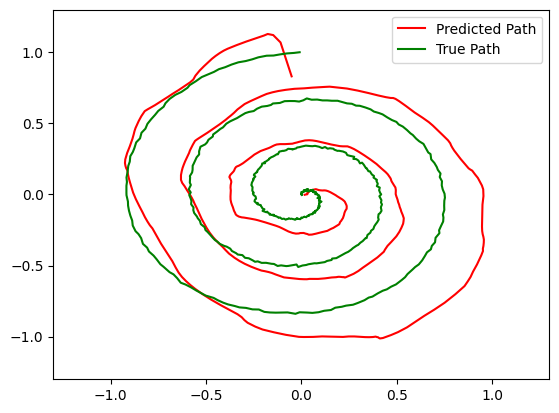

Epoch [700/3000], Train Loss: 0.1089, Val Loss: 0.0270


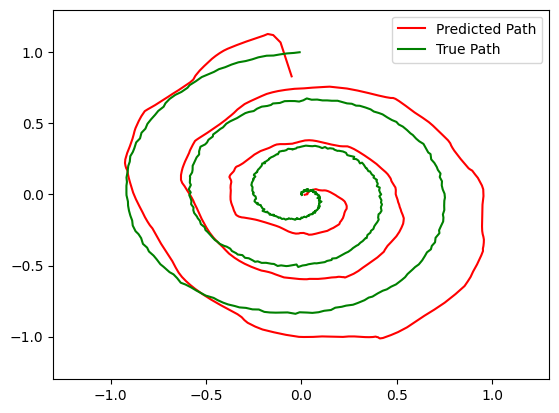

Epoch [800/3000], Train Loss: 0.0965, Val Loss: 0.0270


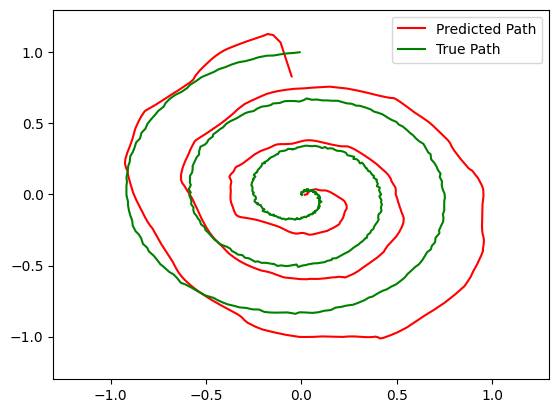

Epoch [900/3000], Train Loss: 0.0937, Val Loss: 0.0270


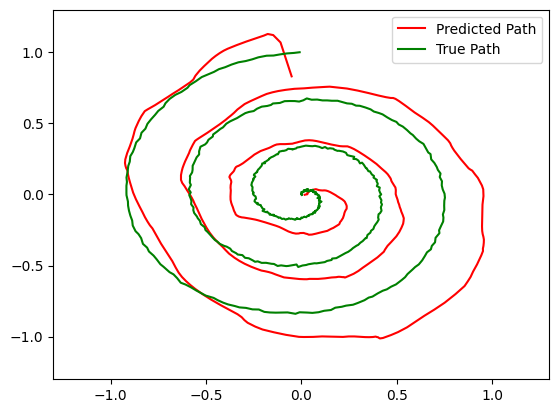

Epoch [1000/3000], Train Loss: 0.1157, Val Loss: 0.0270


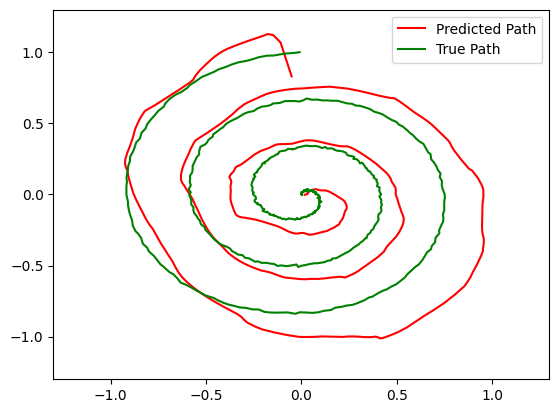

Epoch [1100/3000], Train Loss: 0.1054, Val Loss: 0.0270


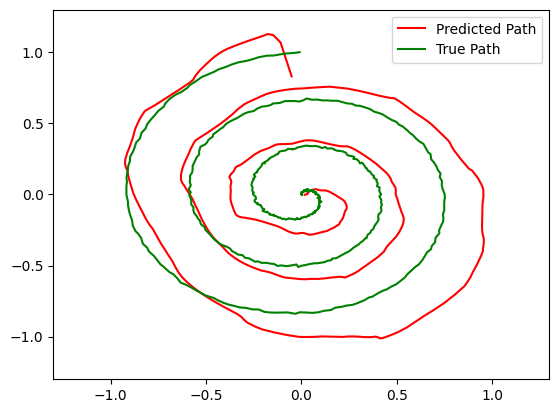

Epoch [1200/3000], Train Loss: 0.1036, Val Loss: 0.0270


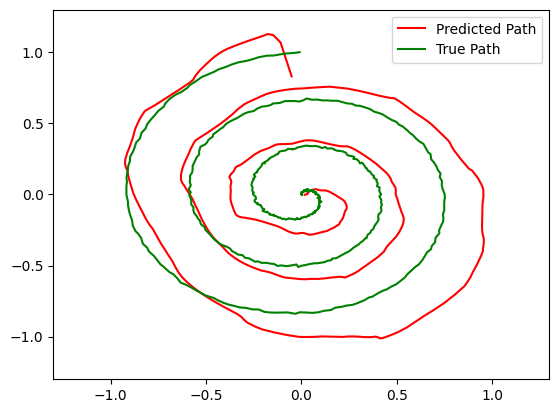

Epoch [1300/3000], Train Loss: 0.0974, Val Loss: 0.0270


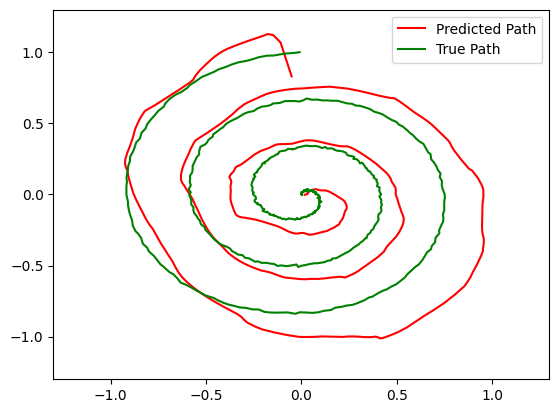

Epoch [1400/3000], Train Loss: 0.1122, Val Loss: 0.0270


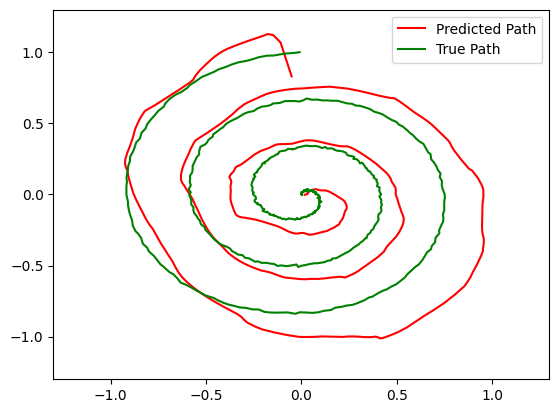

Epoch [1500/3000], Train Loss: 0.1029, Val Loss: 0.0270


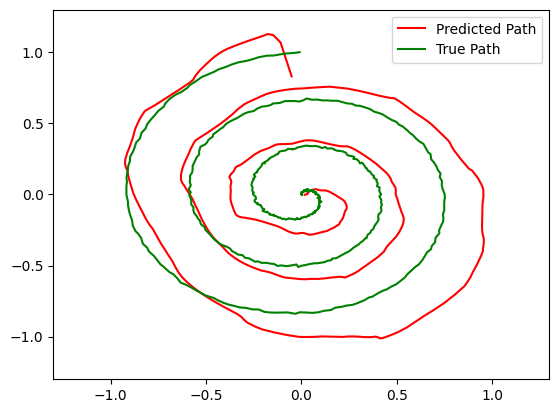

Epoch [1600/3000], Train Loss: 0.0951, Val Loss: 0.0270


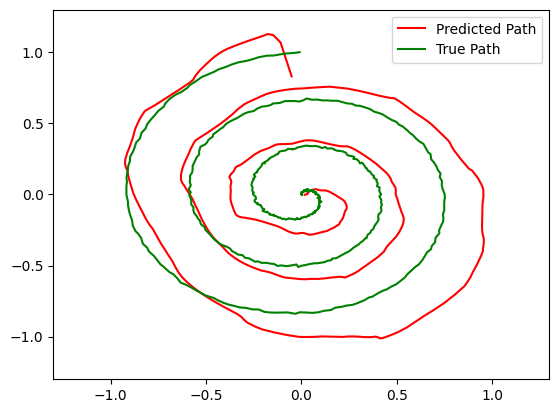

Epoch [1700/3000], Train Loss: 0.0943, Val Loss: 0.0270


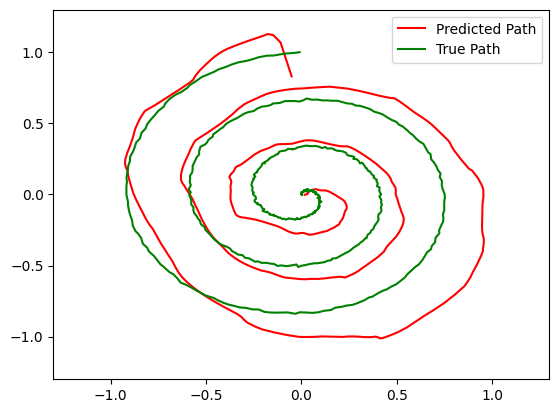

Epoch [1800/3000], Train Loss: 0.0968, Val Loss: 0.0270


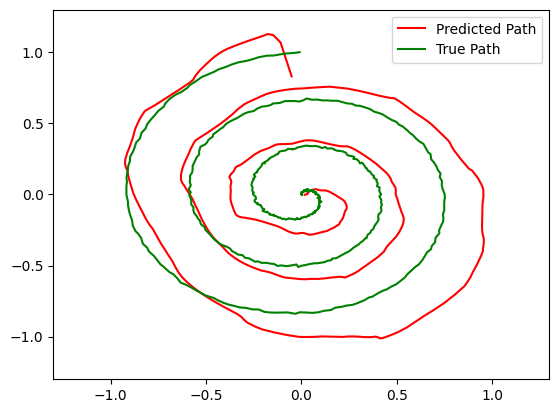

Epoch [1900/3000], Train Loss: 0.1072, Val Loss: 0.0270


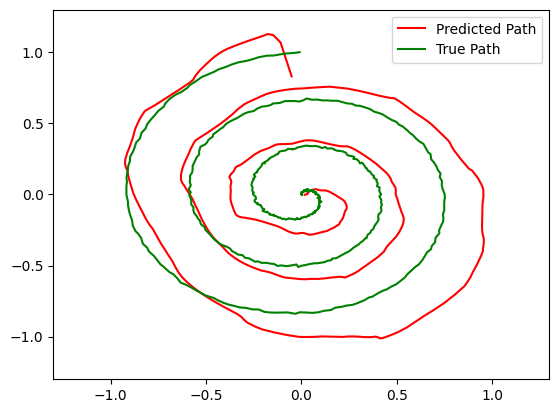

Epoch [2000/3000], Train Loss: 0.0890, Val Loss: 0.0270


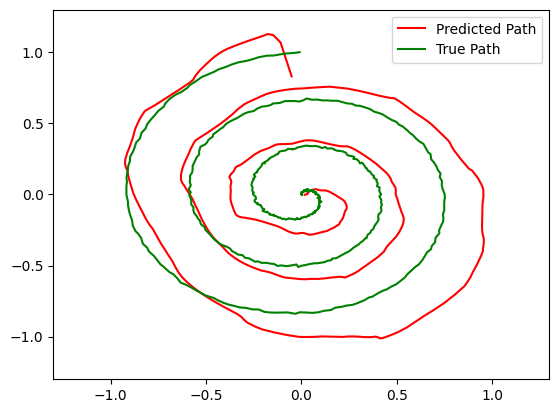

Epoch [2100/3000], Train Loss: 0.1017, Val Loss: 0.0270


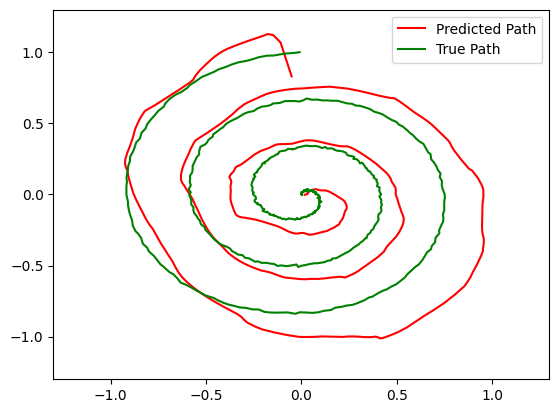

Epoch [2200/3000], Train Loss: 0.0995, Val Loss: 0.0270


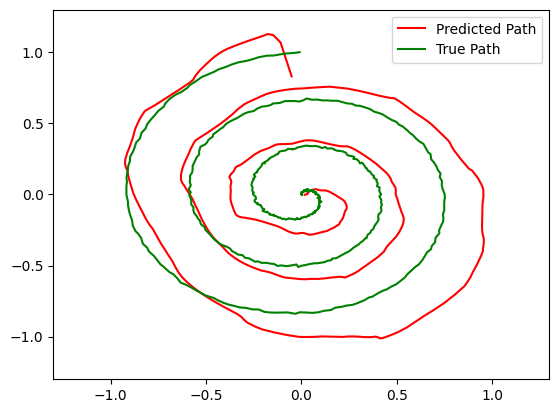

Epoch [2300/3000], Train Loss: 0.0952, Val Loss: 0.0270


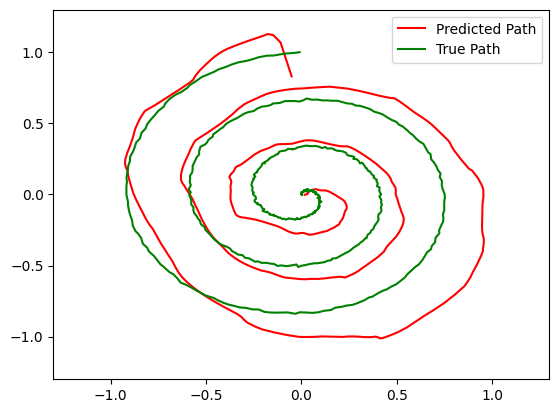

Epoch [2400/3000], Train Loss: 0.1052, Val Loss: 0.0270


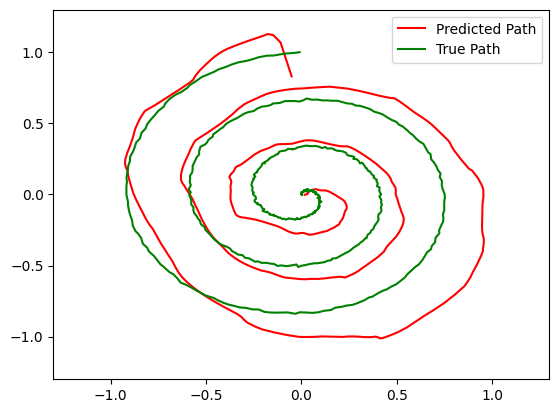

Epoch [2500/3000], Train Loss: 0.0985, Val Loss: 0.0270


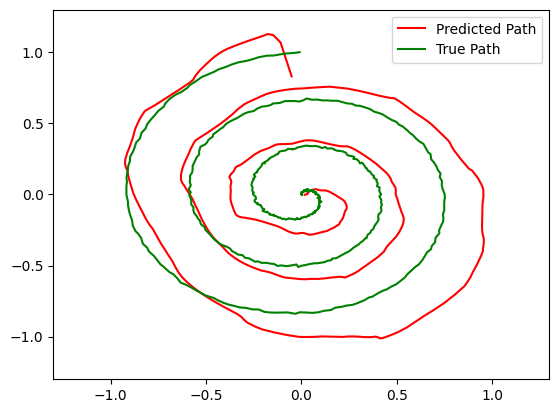

Epoch [2600/3000], Train Loss: 0.0907, Val Loss: 0.0270


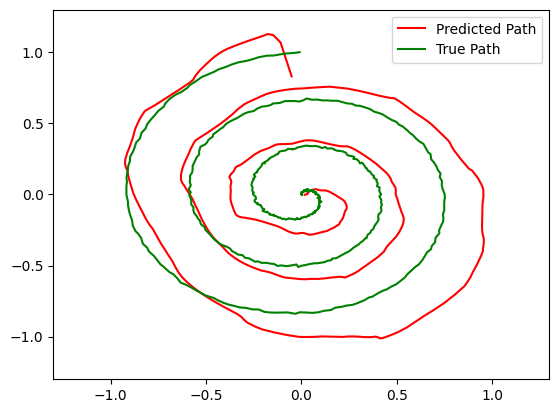

Epoch [2700/3000], Train Loss: 0.1012, Val Loss: 0.0270


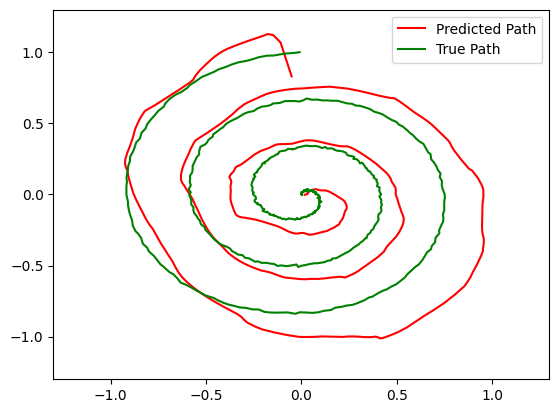

Epoch [2800/3000], Train Loss: 0.1202, Val Loss: 0.0270


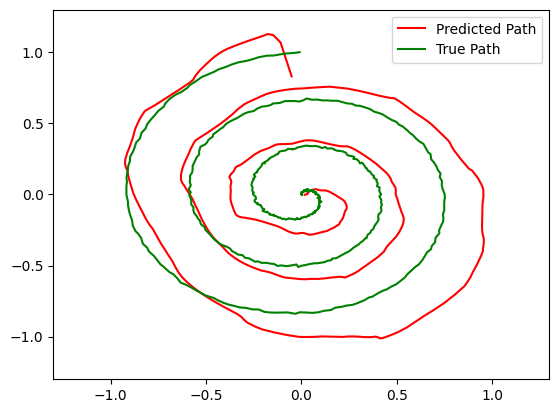

Epoch [2900/3000], Train Loss: 0.1117, Val Loss: 0.0270


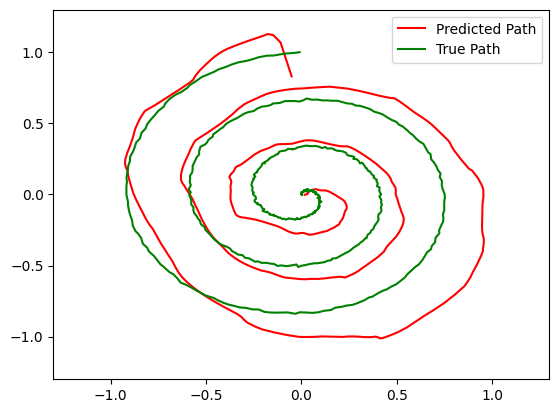

Epoch [3000/3000], Train Loss: 0.1029, Val Loss: 0.0270


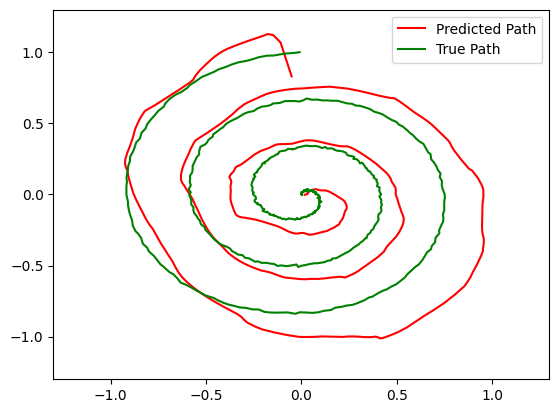

In [24]:
# Hyperparameters
input_dim = 2
hidden_channels = 32
output_dim = 2
num_points = 500
num_turns = 3
learning_rate = 0.005
num_epochs = 3000
seq_len = 3
batch_size = 32

# Generate data
# data = generate_spiral_data(num_points, num_turns)

# Normalise data (both inputs and targets)
# data, mean, std = normalise(data)

# Use normalised sample_data from before
# sample_data

all_inputs = sample_data[:-1, :]
all_targets = sample_data[1:, :]

# Prepare input and target sequences
trajectory_count = max(1, len(all_inputs) - seq_len)
train_inputs = [torch.FloatTensor(all_inputs[i:i + seq_len]) for i in range(trajectory_count)]
train_targets = [torch.FloatTensor(all_targets[i:i + seq_len]) for i in range(trajectory_count)]

# Shuffle and split
random_train_indices = np.arange(len(train_inputs))
np.random.shuffle(random_train_indices)
train_split_index = int(len(random_train_indices) * 0.8)
random_train_indices = random_train_indices[:train_split_index]

train_input_batches = [train_inputs[i] for i in random_train_indices]
train_target_batches = [train_targets[i] for i in random_train_indices]

def create_batches(data_list, batch_size):
    return [data_list[i:i + batch_size] for i in range(0, len(data_list), batch_size)]

train_input_batches = create_batches(train_input_batches, batch_size)
train_target_batches = create_batches(train_target_batches, batch_size)

# Initialize CNN model
cnn_model = CNN(input_dim=input_dim, hidden_channels=hidden_channels, output_dim=output_dim)

# Loss and optimizer
# criterion = nn.MSELoss()
criterion = nn.SmoothL1Loss()
optimizer = optim.Adam(cnn_model.parameters(), lr=learning_rate)

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=500, gamma=0.5)


# Training loop
for epoch in range(num_epochs):
    cnn_model.train()
    total_loss = 0

    for x_batch, y_batch in zip(train_input_batches, train_target_batches):
        x = torch.stack(x_batch)  # [batch_size, seq_len, input_dim]
        y = torch.stack(y_batch)  # [batch_size, seq_len, output_dim]

        optimizer.zero_grad()
        outputs = cnn_model(x)
        loss = criterion(outputs, y)
        total_loss += loss.item()
        loss.backward()
        optimizer.step()
        scheduler.step()

    # Evaluation and plotting every 100 epochs
    if (epoch + 1) % 100 == 0:
        cnn_model.eval()
        with torch.no_grad():
            test_input_tensor = torch.FloatTensor(all_inputs).unsqueeze(0)
            predictions = cnn_model(test_input_tensor)
            np_predictions = predictions.squeeze(0).numpy()
            val_loss = criterion(predictions, torch.FloatTensor(all_targets).unsqueeze(0))

        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {total_loss:.4f}, Val Loss: {val_loss:.4f}")
        
        # Denormalise predictions and targets for plotting in original dataspace
        np_predictions_denorm, _, _ = denormalise(np_predictions, mean, std)
        all_targets_denorm, _, _ = denormalise(all_targets, mean, std)
        
        plt.plot(np_predictions_denorm[:, 0], np_predictions_denorm[:, 1], 'r-', label='Predicted Path')
        plt.plot(all_targets_denorm[:, 0], all_targets_denorm[:, 1], 'g-', label='True Path')
        plt.xlim(-1.3, 1.3)
        plt.ylim(-1.3, 1.3)
        plt.legend()
        plt.show()

[[ 0.12286174  0.00711641]
 [ 0.14139807 -0.00731316]
 [ 0.14043952  0.00129055]
 [ 0.12544348  0.00496745]
 [ 0.12298222  0.02900177]]
(500, 2)
------
[[ 0.12286174  0.00711641]
 [ 0.14139807 -0.00731316]
 [ 0.14043952  0.00129055]
 [ 0.12544348  0.00496745]
 [ 0.12298222  0.02900177]]
(499, 2)
------
[[ 0.14139807 -0.00731316]
 [ 0.14043952  0.00129055]
 [ 0.12544348  0.00496745]
 [ 0.12298222  0.02900177]
 [ 0.14466896  0.01129429]]
(499, 2)
------

On the final epoch:
- CNN has a training loss of 0.0030 and validation loss of 0.0005
- LNN has a training loss of 0.0031 and validation loss of 0.0004

These are comparable neural networks (similar MSE loss values)

In [ ]:
# Save the model (not the state dict)
torch.save(cnn_model, "cnn_model.pt")

In [ ]:
# Load the model
cnn_model = torch.load("cnn_model.pt", weights_only=False)

# Model Inference

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import matplotlib.pyplot as plt

def infer_spiral(model, input_seq, target_seq=None):
    model.eval()
    with torch.no_grad():
        x = torch.FloatTensor(input_seq).unsqueeze(0)  # Shape: [1, seq_len, input_dim]
        predictions = model(x).squeeze(0).numpy()      # Shape: [seq_len, output_dim]

    if target_seq is not None:
        if isinstance(target_seq, torch.Tensor):
            target_seq = target_seq.numpy()
        
        mse = mean_squared_error(target_seq, predictions)
        mae = mean_absolute_error(target_seq, predictions)
        rmse = np.sqrt(mse)

        # Print metrics
        print(f"Inference Metrics:")
        print(f"  MSE  = {mse:.6f}")
        print(f"  RMSE = {rmse:.6f}")
        print(f"  MAE  = {mae:.6f}")

        plt.plot(target_seq[:, 0], target_seq[:, 1], 'g-', label='True Path')
    plt.plot(predictions[:, 0], predictions[:, 1], 'r--', label='Predicted Path')
    plt.legend()
    title = ""
    if isinstance(model,LTCRNN):
        title = "LTC Model Inference"
    elif isinstance(model,CNN):
        title = "CNN Model Inference"
    plt.title(title)
    plt.show()

    return predictions


# Change num_points and num_turns here to give input diff shape
test_data = generate_spiral_data(num_points=200, num_turns=10000)

# Prepare input and target pairs
test_inputs = test_data[:-1, :]    # Inputs: from 0 to N-2
test_targets = test_data[1:, :]    # Targets: from 1 to N-1


# infer_spiral(model, all_inputs, all_targets)
infer_spiral(lnn_model, test_inputs, test_targets)
infer_spiral(cnn_model, test_inputs, test_targets)
# infer_spiral(model, test_inputs[:3], test_targets[:3])

In [ ]:
# Helper function to display datapoints in target, predictions and adversarial predictions
# For debugging attacks
def display_datapoints(test_input, test_target, adv_output, skip=100):
    assert (test_input.shape[0] == test_target.shape[0] == adv_output.shape[0]), "Input, target and adversarial output must have the same number of samples"

    for i in range(0, test_input.shape[0], skip):
        print("-" * 60)
        # print(f"{'Datapoint':^20} {i:^5}")
        print(f"{f'Datapoint {i}':^60}")
        print(f"{'Target Value:':>30} {str(test_target[i]):>30}")
        print(f"{'Original Prediction:':>30} {str(test_input[i]):>30}")
        print(f"{'Adversarial Prediction:':>30} {str(adv_output[i]):>30}")
    print("-" * 20)

# Robustness Metrics Function

In [ ]:
# Helper function to calculate and display robustness metrics, given an adversarial output and original output

def get_robustness_metrics(model, output, adv_output_tensor, target_tensor):
    orig_loss = F.mse_loss(output, target_tensor).item()
    adv_loss = F.mse_loss(adv_output_tensor, target_tensor).item()
    robustness_ratio = (adv_loss - orig_loss) / (orig_loss + 1e-8)
    deviation = torch.norm(output - adv_output_tensor).item()

    # Print robustness metrics
    model_type = 'LNN' if isinstance(model, LTCRNN) else 'CNN'
    print(f"[{model_type}] | Original Loss: {orig_loss:.4f} | Adversarial Loss: {adv_loss:.4f} | Degradation: {robustness_ratio:.2%} | Deviation: {deviation:.4f}")

In [ ]:
print(F)

# FGSM Attack

In [ ]:
def run_manual_fgsm_attack(model, input_seq, target_seq, epsilon=0.05):
    model.eval()

    # Convert to tensors
    input_tensor = torch.FloatTensor(input_seq).unsqueeze(0).requires_grad_(True)  # [1, seq_len, input_dim]
    target_tensor = torch.FloatTensor(target_seq).unsqueeze(0)                      # [1, seq_len, output_dim]

    # Forward pass
    output = model(input_tensor)
    loss = F.mse_loss(output, target_tensor)

    # Backward pass to compute gradients
    model.zero_grad()
    loss.backward()

    # Generate perturbation using the sign of the gradient
    perturbation = epsilon * input_tensor.grad.data.sign()
    adv_input = input_tensor + perturbation
    adv_input = adv_input.detach()

    # Get adversarial output
    adv_output_tensor = model(adv_input).detach()
    adv_output = adv_output_tensor.numpy()
    adv_output_tensor = adv_output_tensor.squeeze(0)
    original_output = output.squeeze(0).detach().numpy()

    # Display metrics
    get_robustness_metrics(model, output, adv_output_tensor, target_tensor)

    # Plot results
    plt.plot(target_seq[:, 0], target_seq[:, 1], 'g-', label='True Path')
    plt.plot(original_output[:, 0], original_output[:, 1], 'r--', label='Original Prediction')
    plt.plot(adv_output[:, 0], adv_output[:, 1], 'b--', label='Adversarial Prediction')
    plt.legend()
    if isinstance(model,LTCRNN):
        title = f"Manual FGSM Attack (epsilon={epsilon}) on LTC Model"
    elif isinstance(model,CNN):
        title = f"Manual FGSM Attack (epsilon={epsilon}) on CNN"
    plt.title(title)
    plt.show()

    return adv_output

In [ ]:
test_data = generate_spiral_data(400, 4)
test_input = test_data[:-1]
test_target = test_data[1:]

# Run attack on LNN
run_manual_fgsm_attack(lnn_model, test_input, test_target, epsilon=0.05)

# Run attack on CNN
run_manual_fgsm_attack(cnn_model, test_input, test_target, epsilon=0.05)

# PGD Attack

In [ ]:
def run_pgd_attack(model, input_seq, target_seq, epsilon=0.05, alpha=0.01, num_iter=10):
    model.eval()

    # Prepare inputs
    input_tensor = torch.FloatTensor(input_seq).unsqueeze(0)
    target_tensor = torch.FloatTensor(target_seq).unsqueeze(0)

    adv_input = input_tensor.clone().detach().requires_grad_(True)

    for _ in range(num_iter):
        output = model(adv_input)
        loss = F.mse_loss(output, target_tensor)

        model.zero_grad()
        loss.backward()

        # Gradient ascent: move in the direction that increases loss
        with torch.no_grad():
            adv_input += alpha * adv_input.grad.sign()

            # Project perturbation back into epsilon-ball of original input
            perturbation = torch.clamp(adv_input - input_tensor, min=-epsilon, max=epsilon)
            adv_input = torch.clamp(input_tensor + perturbation, min=input_tensor.min(), max=input_tensor.max())
            adv_input.requires_grad_(True)

    # Final prediction
    adv_output = model(adv_input).squeeze(0).detach().numpy()
    original_output = model(input_tensor).squeeze(0).detach().numpy()

    # Display metrics
    get_robustness_metrics(model, original_output, adv_output, target_tensor)


    # Plot comparison
    plt.plot(target_seq[:, 0], target_seq[:, 1], 'g-', label='True Path')
    plt.plot(original_output[:, 0], original_output[:, 1], 'r--', label='Original Prediction')
    plt.plot(adv_output[:, 0], adv_output[:, 1], 'b--', label='PGD Adversarial Prediction')
    plt.legend()
    if isinstance(model,LTCRNN):
        title = f"PGD Attack (epsilon={epsilon}, alpha={alpha}, iter={num_iter}) on LTC Model"
    elif isinstance(model,CNN):
        title = f"PGD Attack (epsilon={epsilon}, alpha={alpha}, iter={num_iter}) on CNN"
    plt.title(title)
    plt.show()

    return adv_output

In [ ]:
test_data = generate_spiral_data(400, 4)
test_input = test_data[:-1]
test_target = test_data[1:]

# Run attack on LNN
run_pgd_attack(lnn_model, test_input, test_target, epsilon=0.05, alpha=0.01, num_iter=15)

# Run attack on CNN
run_pgd_attack(cnn_model, test_input, test_target, epsilon=0.05, alpha=0.01, num_iter=15)

# C&W Attack - not working yet

In [ ]:
def run_cw_l2_attack(model, input_seq, target_seq, c=1e-3, kappa=0, num_iter=100, lr=1e-2):
    model.eval()

    # Prepare inputs
    input_tensor = torch.FloatTensor(input_seq).unsqueeze(0)
    target_tensor = torch.FloatTensor(target_seq).unsqueeze(0)

    # Ensure inputs are in (0, 1) for atanh stability
    eps = 1e-6
    input_tensor_clamped = torch.clamp(input_tensor, eps, 1 - eps)
    w_init = torch.atanh(2 * input_tensor_clamped - 1)

    # Create optimization variable
    w = w_init.clone().detach().requires_grad_(True)
    optimizer = torch.optim.Adam([w], lr=lr)

    for _ in range(num_iter):
        adv_input = 0.5 * (torch.tanh(w) + 1)  # Ensure valid input range
        output = model(adv_input)

        # Loss: L2 distance + adversarial loss
        l2_dist = torch.norm(adv_input - input_tensor, p=2)
        adv_loss = -F.mse_loss(output, target_tensor, reduction='sum')  # make it deviate

        loss = l2_dist + c * adv_loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Final adversarial input
    adv_input = 0.5 * (torch.tanh(w) + 1).detach()
    adv_output = model(adv_input).squeeze(0).detach().numpy()
    original_output = model(input_tensor).squeeze(0).detach().numpy()

    # Display metrics
    get_robustness_metrics(model, original_output, adv_output, target_tensor)


    # Plot comparison
    plt.plot(target_seq[:, 0], target_seq[:, 1], 'g-', label='True Path')
    plt.plot(original_output[:, 0], original_output[:, 1], 'r--', label='Original Prediction')
    plt.plot(adv_output[:, 0], adv_output[:, 1], 'b--', label='CW Adversarial Prediction')
    plt.legend()

    if isinstance(model,LTCRNN):
        title = f"C&W L2 Attack (c={c}, iter={num_iter}) on LTC Model"
    elif isinstance(model,CNN):
        title = f"C&W L2 Attack (c={c}, iter={num_iter}) on CNN"
    plt.title(title)

    plt.show()

    return adv_output


In [ ]:
test_data = generate_spiral_data(400, 4)
test_input = test_data[:-1]
test_target = test_data[1:]

# Run attack on LNN
adv_output = run_cw_l2_attack(lnn_model, test_input, test_target, c=1e-4, lr=1e-3)

# Run attack on CNN
adv_output = run_cw_l2_attack(cnn_model, test_input, test_target, c=1e-4, lr=1e-3)

# DeepFool Attack

In [ ]:
def run_deepfool_like_attack(model, input_seq, target_seq, max_iter=20, step_size=0.005):
    model.eval()

    input_tensor = torch.FloatTensor(input_seq).unsqueeze(0).requires_grad_(True)  # [1, T, D]
    target_tensor = torch.FloatTensor(target_seq).unsqueeze(0)                     # [1, T, D]
    adv_input = input_tensor.clone().detach().requires_grad_(True)

    perturbation = torch.zeros_like(adv_input)

    for _ in range(max_iter):
        output = model(adv_input)
        loss = F.mse_loss(output, target_tensor, reduction='sum')

        model.zero_grad()
        loss.backward()

        grad = adv_input.grad.data
        grad_norm = torch.norm(grad)

        if grad_norm == 0:
            break

        # Compute minimal step in direction of gradient to move away from true output
        # r_i = (loss.item() / (grad_norm ** 2)) * grad
        r_i = step_size * grad / grad_norm
        perturbation += r_i
        # adv_input = input_tensor + (1 + overshoot) * perturbation
        adv_input = input_tensor + perturbation
        adv_input = adv_input.clone().detach().requires_grad_(True)

    # Final outputs
    adv_output = model(adv_input).squeeze(0).detach().numpy()
    original_output = model(input_tensor).squeeze(0).detach().numpy()

    # Display Metrics
    get_robustness_metrics(model, original_output, adv_output, target_tensor)

    # Plot results
    plt.plot(target_seq[:, 0], target_seq[:, 1], 'g-', label='True Path')
    plt.plot(original_output[:, 0], original_output[:, 1], 'r--', label='Original Prediction')
    plt.plot(adv_output[:, 0], adv_output[:, 1], 'b--', label='DeepFool-like Adversarial')
    plt.legend()

    if isinstance(model,LTCRNN):
        title = f"DeepFool-Like Attack (iter={max_iter}, step_size={step_size}) on LTC Model"
    elif isinstance(model,CNN):
        title = f"DeepFool-Like Attack (iter={max_iter}, step_size={step_size}) on CNN"
    plt.title(title)

    plt.show()

    return adv_output


In [ ]:
test_data = generate_spiral_data(400, 4)
test_input = test_data[:-1]
test_target = test_data[1:]

# Run attack on LNN
adv_output_cw = run_deepfool_like_attack(lnn_model, test_input, test_target, step_size=0.005)

# Run attack on CNN
adv_output_cw = run_deepfool_like_attack(cnn_model, test_input, test_target, step_size=0.005)

# SPSA (Simultaneous Perturbation Stochastic Approximation)

In [ ]:
def run_spsa_attack(model, input_seq, target_seq, epsilon=0.05, num_iter=20, delta=0.01, learning_rate=0.01):
    model.eval()

    # Inputs
    input_tensor = torch.FloatTensor(input_seq).unsqueeze(0)
    target_tensor = torch.FloatTensor(target_seq).unsqueeze(0)

    # Initialize adversarial input
    adv_input = input_tensor.clone().detach()
    
    for _ in range(num_iter):
        # Generate random perturbation vector (same shape as input)
        perturb = torch.sign(torch.randn_like(input_tensor))

        # Evaluate loss at positive and negative perturbations
        input_plus = adv_input + delta * perturb
        input_minus = adv_input - delta * perturb

        input_plus = input_plus.detach()
        input_minus = input_minus.detach()

        loss_plus = F.mse_loss(model(input_plus), target_tensor, reduction='sum')
        loss_minus = F.mse_loss(model(input_minus), target_tensor, reduction='sum')

        # Approximate gradient (finite difference)
        grad_estimate = (loss_plus - loss_minus) / (2 * delta) * perturb

        # Update input in direction of increasing loss
        adv_input = adv_input + learning_rate * torch.sign(grad_estimate)

        # Clip to stay within epsilon of original input
        perturbation = torch.clamp(adv_input - input_tensor, min=-epsilon, max=epsilon)
        adv_input = torch.clamp(input_tensor + perturbation, min=input_tensor.min(), max=input_tensor.max())

    # Final output
    adv_output = model(adv_input).squeeze(0).detach().numpy()
    original_output = model(input_tensor).squeeze(0).detach().numpy()

    # Display Metrics
    get_robustness_metrics(model, original_output, adv_output, target_tensor)



    # Plot
    plt.plot(target_seq[:, 0], target_seq[:, 1], 'g-', label='True Path')
    plt.plot(original_output[:, 0], original_output[:, 1], 'r--', label='Original Prediction')
    plt.plot(adv_output[:, 0], adv_output[:, 1], 'b--', label='SPSA Adversarial')
    plt.legend()

    if isinstance(model,LTCRNN):
        title = f"SPSA Attack (epsilon={epsilon}, iter={num_iter}, delta={delta}) on LTC Model"
    elif isinstance(model,CNN):
        title = f"SPSA Attack (epsilon={epsilon}, iter={num_iter}, delta={delta}) on CNN"
    plt.title(title)

    plt.show()

    return adv_output


In [ ]:
test_data = generate_spiral_data(400, 4)
test_input = test_data[:-1]
test_target = test_data[1:]

# Run attack on LNN
adv_output_cw = run_spsa_attack(lnn_model, test_input, test_target)

# Run attack on CNN
adv_output_cw = run_spsa_attack(cnn_model, test_input, test_target)

# *Temporal Sensitivity Attacks*
Time-Warping Attack and Continuous-Time Adversarial Perturbation

In [ ]:
# Helper function for both temporal sensitivity attacks (time-warping attack and continuous-time adversarial perturbation)
# Differentiable Linear interpolation


def torch_interp1d(x, xp, fp):
    """
    Differentiable linear interpolation: interpolates fp (at xp) to positions x.
    """
    inds = torch.searchsorted(xp, x, right=True).clamp(min=1, max=len(xp) - 1)
    x0, x1 = xp[inds - 1], xp[inds]
    f0, f1 = fp[inds - 1], fp[inds]
    slope = (f1 - f0) / (x1 - x0 + 1e-12)
    return f0 + slope * (x - x0)


# Time-Warping Attack

In [ ]:
"""
This function implements a time-warping adversarial attack on a liquid neural network by optimizing small perturbations to the input time grid, rather than the input values themselves. It defines a set of learnable control points that deform the time axis, then resamples the original input sequence along the warped time grid using differentiable linear interpolation. The perturbations are trained via gradient ascent to maximize the model's output error with respect to the true target, exposing the model's sensitivity to temporal distortions.
"""


import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

def run_time_warping_attack(model, input_seq, target_seq, epsilon=0.1, num_control_points=10, num_iter=50, lr=1e-2):
    model.eval()

    # Prepare input and target tensors
    input_seq = torch.FloatTensor(input_seq)
    target_tensor = torch.FloatTensor(target_seq).unsqueeze(0)
    T, D = input_seq.shape

    time = torch.linspace(0, 1, T)
    control_x = torch.linspace(0, 1, num_control_points)
    delta_t = torch.zeros(num_control_points, requires_grad=True)

    optimizer = torch.optim.Adam([delta_t], lr=lr)

    for _ in range(num_iter):
        # Perturb control points and ensure validity
        warped_control_y = torch.clamp(control_x + torch.clamp(delta_t, -epsilon, epsilon), 0, 1)
        warped_control_y_sorted, _ = torch.sort(warped_control_y)

        # Interpolate full warped time
        warped_time = torch_interp1d(time, control_x, warped_control_y_sorted)

        # Interpolate each input dimension over warped time
        input_seq_warped = torch.stack([
            torch_interp1d(warped_time, time, input_seq[:, d])
            for d in range(D)
        ], dim=1)  # shape: [T, D]

        adv_input = input_seq_warped.unsqueeze(0)  # shape: [1, T, D]
        output = model(adv_input)
        loss = F.mse_loss(output, target_tensor)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Final prediction
    adv_output = model(adv_input).squeeze(0).detach().numpy()
    original_output = model(input_seq.unsqueeze(0)).squeeze(0).detach().numpy()

    # Display Metrics
    get_robustness_metrics(model, original_output, adv_output, target_tensor)

    # Plot
    plt.plot(target_seq[:, 0], target_seq[:, 1], 'g-', label='True Path')
    plt.plot(original_output[:, 0], original_output[:, 1], 'r--', label='Original Prediction')
    plt.plot(adv_output[:, 0], adv_output[:, 1], 'b--', label='Time-Warped Adversarial')
    plt.legend()

    if isinstance(model,LTCRNN):
        title = f"Time-Warping Attack (ε={epsilon}, iter={num_iter}) on LTC Model"
    elif isinstance(model,CNN):
        title = f"Time-Warping Attack (ε={epsilon}, iter={num_iter}) on CNN"
    plt.title(title)

    plt.show()

    return adv_output


In [ ]:
test_data = generate_spiral_data(400, 4)
test_input = test_data[:-1]
test_target = test_data[1:]

# Run attack on LNN
adv_output_cw = run_time_warping_attack(lnn_model, test_input, test_target, epsilon=0.1, num_control_points=10, num_iter=50, lr=1e-2)

# Run attack on CNN
adv_output_cw = run_time_warping_attack(cnn_model, test_input, test_target, epsilon=0.1, num_control_points=10, num_iter=50, lr=1e-2)

# Continuous-Time Adversarial Perturbation Attack

In [ ]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

def run_continuous_time_perturbation_attack(model, input_seq, target_seq, epsilon=0.1, num_control_points=10, num_iter=50, lr=1e-2):
    """
    This function implements a continuous-time adversarial perturbation attack on a liquid neural network.
    It defines a smooth additive perturbation function δ(t), parameterized by a small number of control points
    across the input time sequence. The perturbation is optimized via gradient ascent to maximize the model's
    output error, directly modifying the input signal over time while keeping the distortion bounded.
    """

    model.eval()

    # Convert to tensors
    input_seq = torch.FloatTensor(input_seq)
    target_tensor = torch.FloatTensor(target_seq).unsqueeze(0)
    T, D = input_seq.shape

    time = torch.linspace(0, 1, T)
    control_x = torch.linspace(0, 1, num_control_points)
    
    # Learnable perturbations δ(t): shape [num_control_points, D]
    delta_values = torch.zeros(num_control_points, D, requires_grad=True)
    optimizer = torch.optim.Adam([delta_values], lr=lr)

    for _ in range(num_iter):
        # Interpolate δ(t) from control points to full sequence
        perturbation = torch.stack([
            torch_interp1d(time, control_x, delta_values[:, d])
            for d in range(D)
        ], dim=1)  # shape: [T, D]

        # Clamp perturbation to stay within ±epsilon
        perturbation = torch.clamp(perturbation, -epsilon, epsilon)

        # Add perturbation to input
        adv_input = (input_seq + perturbation).unsqueeze(0)  # shape: [1, T, D]
        output = model(adv_input)
        loss = F.mse_loss(output, target_tensor)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Final prediction
    adv_output = model(adv_input).squeeze(0).detach().numpy()
    original_output = model(input_seq.unsqueeze(0)).squeeze(0).detach().numpy()

    # Display Metrics
    get_robustness_metrics(model, original_output, adv_output, target_tensor)


    # Plot
    plt.plot(target_seq[:, 0], target_seq[:, 1], 'g-', label='True Path')
    plt.plot(original_output[:, 0], original_output[:, 1], 'r--', label='Original Prediction')
    plt.plot(adv_output[:, 0], adv_output[:, 1], 'b--', label='CT Adversarial Prediction')
    plt.legend()

    if isinstance(model,LTCRNN):
        title = f"Continuous-Time Perturbation Attack (ε={epsilon}, iter={num_iter}) on LTC Model"
    elif isinstance(model,CNN):
        title = f"Continuous-Time Perturbation Attack (ε={epsilon}, iter={num_iter}) on CNN"
    plt.title(title)

    plt.show()

    return adv_output


In [ ]:
test_data = generate_spiral_data(400, 4)
test_input = test_data[:-1]
test_target = test_data[1:]

# Run attack on LNN
adv_output_cw = run_continuous_time_perturbation_attack(lnn_model, test_input, test_target, epsilon=0.1, num_control_points=10, num_iter=50, lr=1e-2)

# Run attack on CNN
adv_output_cw = run_continuous_time_perturbation_attack(cnn_model, test_input, test_target, epsilon=0.1, num_control_points=10, num_iter=50, lr=1e-2)